In [9]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import wfdb.processing


In [11]:
import os
import requests
import zipfile

def download_and_extract_mitdb(destination="data/mitdb"):
    url = "https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip"
    zip_path = "mitdb.zip"
    
    # Baixar o arquivo ZIP
    print("Baixando MIT-BIH Arrhythmia Database...")
    response = requests.get(url, stream=True)
    
    if response.status_code == 200:
        with open(zip_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=1024):
                file.write(chunk)
        print("Download concluído.")
    else:
        print("Erro ao baixar o arquivo.")
        return

    # Extrair os arquivos
    print("Extraindo arquivos...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(destination)
    
    print(f"Arquivos extraídos para {destination}")
    
    # Remover o ZIP
    os.remove(zip_path)

# Executar a função
download_and_extract_mitdb()


Baixando MIT-BIH Arrhythmia Database...
Download concluído.
Extraindo arquivos...
Arquivos extraídos para data/mitdb


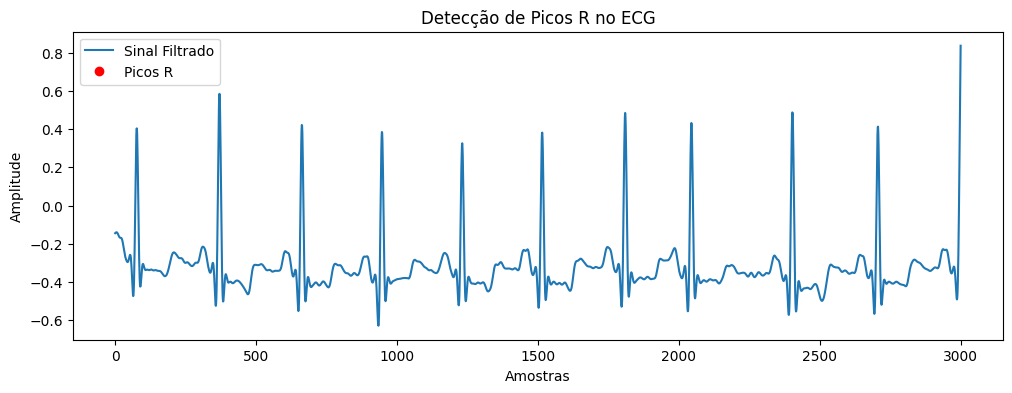

In [16]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sp_signal  # Renomeando para evitar conflito

def load_ecg(record_name="100"):
    record_path = f"data/mitdb/mit-bih-arrhythmia-database-1.0.0/{record_name}"
    
    if not os.path.exists(f"{record_path}.dat"):
        print(f"Erro: Arquivo {record_name} não encontrado em {record_path}.")
        return None

    record = wfdb.rdrecord(record_path, sampto=3000)  # Lê até 3000 amostras
    ecg_signal = record.p_signal[:, 0]  # Pega apenas um canal

    return ecg_signal

# Filtro passa-baixa para remover ruídos de alta frequência
def lowpass_filter(signal_data, cutoff=20, fs=360, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = sp_signal.butter(order, normal_cutoff, btype='low', analog=False)  # Usando scipy.signal como sp_signal
    return sp_signal.filtfilt(b, a, signal_data)  # Usando scipy.signal.filtfilt

# Detecção dos picos R usando a derivada da curva e limiares
def detect_r_peaks(signal_data, threshold=0.6):
    diff_signal = np.diff(signal_data)  # Derivada do sinal
    peaks, _ = sp_signal.find_peaks(diff_signal, height=threshold)  # Detecta picos
    return peaks

ecg_signal = load_ecg()  # Carrega o sinal ECG
if ecg_signal is not None:
    filtered_signal = lowpass_filter(ecg_signal)  # Filtra o sinal
    r_peaks = detect_r_peaks(filtered_signal)  # Detecta os picos R

    # Plotando o ECG e os picos R detectados
    plt.figure(figsize=(12, 4))
    plt.plot(filtered_signal, label="Sinal Filtrado")
    plt.plot(r_peaks, filtered_signal[r_peaks], "ro", label="Picos R")
    plt.legend()
    plt.title("Detecção de Picos R no ECG")
    plt.xlabel("Amostras")
    plt.ylabel("Amplitude")
    plt.show()


In [23]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sp_signal  # Renomeando para evitar conflito
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Função para carregar o sinal ECG
def load_ecg(record_name="100"):
    record_path = f"data/mitdb/mit-bih-arrhythmia-database-1.0.0/{record_name}"
    
    if not os.path.exists(f"{record_path}.dat"):
        print(f"Erro: Arquivo {record_name} não encontrado em {record_path}.")
        return None

    record = wfdb.rdrecord(record_path, sampto=3000)  # Lê até 3000 amostras
    ecg_signal = record.p_signal[:, 0]  # Pega apenas um canal

    return ecg_signal

# Filtro passa-baixa para remover ruídos de alta frequência
def lowpass_filter(signal_data, cutoff=20, fs=360, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = sp_signal.butter(order, normal_cutoff, btype='low', analog=False)  # Usando scipy.signal como sp_signal
    return sp_signal.filtfilt(b, a, signal_data)  # Usando scipy.signal.filtfilt

# Detecção dos picos R usando a derivada da curva e limiares
def detect_r_peaks(signal_data, threshold=0.2):
    diff_signal = np.diff(signal_data)  # Derivada do sinal
    peaks, _ = sp_signal.find_peaks(diff_signal, height=threshold)  # Detecta picos
    return peaks

# Função para criar características e rótulos
def create_labels(signal_data, r_peaks, window_size=200):
    features = []
    labels = []
    
    for i in range(1, len(r_peaks)-1):
        # Extrai um pedaço de sinal em torno dos picos R
        start = r_peaks[i] - window_size // 2
        end = r_peaks[i] + window_size // 2
        
        if start >= 0 and end < len(signal_data):
            window = signal_data[start:end]
            features.append(window)
            
            # Rótulo: 1 para batimento normal, 0 para anormal (simulação simples)
            if signal_data[r_peaks[i]] > signal_data[r_peaks[i-1]] and signal_data[r_peaks[i]] > signal_data[r_peaks[i+1]]:
                labels.append(1)  # Batimento normal
            else:
                labels.append(0)  # Batimento anormal
    
    return np.array(features), np.array(labels)

# Carrega e processa o sinal ECG
ecg_signal = load_ecg()  # Carrega o sinal ECG
if ecg_signal is not None:
    filtered_signal = lowpass_filter(ecg_signal)  # Filtra o sinal
    r_peaks = detect_r_peaks(filtered_signal)  # Detecta os picos R

    # Criar características e rótulos para treinamento
    features, labels = create_labels(filtered_signal, r_peaks)

    # Verificar se há características para continuar
    if features.shape[0] > 0:
        # Dividir em conjunto de treinamento e teste
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

        # Criar e treinar o modelo SVM
        clf = SVC(kernel='linear', C=1)
        clf.fit(X_train, y_train)

        # Fazer previsões
        y_pred = clf.predict(X_test)

        # Avaliar a acurácia
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Acurácia do classificador SVM: {accuracy * 100:.2f}%")

        # Plotando o ECG e os picos R detectados
        plt.figure(figsize=(12, 4))
        plt.plot(filtered_signal, label="Sinal Filtrado")
        plt.plot(r_peaks, filtered_signal[r_peaks], "ro", label="Picos R")
        plt.legend()
        plt.title("Detecção de Picos R no ECG")
        plt.xlabel("Amostras")
        plt.ylabel("Amplitude")
        plt.show()
    else:
        print("Erro: Nenhuma característica gerada para treinamento.")
else:
    print("Erro: Não foi possível carregar o sinal ECG.")


Erro: Nenhuma característica gerada para treinamento.
